EDA consists of two main sections:
1. the distributions of each column
2. the relationship between each column and the target

In each step, finding and action are documented

---

Summary of feature engineering plan to be done in the training part:
- drop rows (from 2.1): `transac_type not in (TRANSFER, CASH_OUT)`
- rule (from 2.1): `if transac_type not in (TRANSFER, CASH_OUT), predict non-fraud`
- drop column (from 2.2): `is_flagged_fraud`
- new feature (from 2.5): `hour_of_day = MOD(time_ind, 24)`
- new feature (from 2.5): `day_of_month = CAST((time_ind / 24) + 1 AS INTEGER)`

In [1]:
import os
import duckdb

get_path = lambda :os.path.join('..','data','fraud_mock.csv')

In [2]:
!wc -l {get_path()}

6362621 ../data/fraud_mock.csv


In [3]:
duckdb.sql(f"SELECT * FROM '{get_path()}' LIMIT 5").show()

┌──────────┬──────────────┬──────────┬────────────┬──────────┬─────────────┬────────────┬─────────┬─────────────┬──────────┬──────────────────┐
│ time_ind │ transac_type │  amount  │  src_acc   │ src_bal  │ src_new_bal │  dst_acc   │ dst_bal │ dst_new_bal │ is_fraud │ is_flagged_fraud │
│  int64   │   varchar    │  double  │  varchar   │  double  │   double    │  varchar   │ double  │   double    │  int64   │      int64       │
├──────────┼──────────────┼──────────┼────────────┼──────────┼─────────────┼────────────┼─────────┼─────────────┼──────────┼──────────────────┤
│        1 │ PAYMENT      │  9839.64 │ acc910286  │ 170136.0 │   160296.36 │ acc298089  │     0.0 │         0.0 │        0 │                0 │
│        1 │ PAYMENT      │  1864.28 │ acc6597009 │  21249.0 │    19384.72 │ acc8726693 │     0.0 │         0.0 │        0 │                0 │
│        1 │ TRANSFER     │    181.0 │ acc1796908 │    181.0 │         0.0 │ acc4938640 │     0.0 │         0.0 │        1 │            

# 1. Distributions

## 1.1 only ~8k out of ~6M transactions are fraudulent, meaning the target is highly imbalance.

In [4]:
print('Distribution of is_fraud')
duckdb.sql(
f"""
SELECT 
    is_fraud,
    COUNT(*) AS total
FROM '{get_path()}'
GROUP BY is_fraud
ORDER BY total
"""
).show()

Distribution of is_fraud
┌──────────┬─────────┐
│ is_fraud │  total  │
│  int64   │  int64  │
├──────────┼─────────┤
│        1 │    8213 │
│        0 │ 6354407 │
└──────────┴─────────┘



## 1.2 the distribution of 'transac_type' is also not even.

In [5]:
print('Distribution of transac_type')
duckdb.sql(
f"""
SELECT 
    transac_type,
    COUNT(*) AS total
FROM '{get_path()}'
GROUP BY transac_type
ORDER BY total DESC
"""
).show()

Distribution of transac_type
┌──────────────┬─────────┐
│ transac_type │  total  │
│   varchar    │  int64  │
├──────────────┼─────────┤
│ CASH_OUT     │ 2237500 │
│ PAYMENT      │ 2151495 │
│ CASH_IN      │ 1399284 │
│ TRANSFER     │  532909 │
│ DEBIT        │   41432 │
└──────────────┴─────────┘



## 1.3 there are ~9 million unique accounts

In [6]:
duckdb.sql(
f"""
WITH ALL_ACC AS (
    SELECT DISTINCT src_acc as acc FROM '{get_path()}'
    UNION
    SELECT DISTINCT dst_acc as acc FROM '{get_path()}'
)

SELECT COUNT(acc) FROM ALL_ACC
"""
)

┌────────────┐
│ count(acc) │
│   int64    │
├────────────┤
│    9073900 │
└────────────┘

## 1.4 we could infer which accounts are merchant by examining the total number of transactions

Merchant accounts normally have more receiving transactions than sending ones.

In [7]:
duckdb.sql(
f"""
SELECT 
    COUNT (DISTINCT src_acc) as total_src,
    COUNT (DISTINCT dst_acc) as total_dst
FROM '{get_path()}'
"""
).show()

duckdb.sql(
f"""
SELECT 
    src_acc,
    COUNT(*) AS total_transactions
FROM '{get_path()}'
GROUP BY src_acc
ORDER BY total_transactions DESC
LIMIT 10
"""
).show()

duckdb.sql(
f"""
SELECT 
    dst_acc,
    COUNT(*) AS total_transactions
FROM '{get_path()}'
GROUP BY dst_acc
ORDER BY total_transactions DESC
LIMIT 10
"""
).show()

┌───────────┬───────────┐
│ total_src │ total_dst │
│   int64   │   int64   │
├───────────┼───────────┤
│   6353307 │   2722362 │
└───────────┴───────────┘

┌────────────┬────────────────────┐
│  src_acc   │ total_transactions │
│  varchar   │       int64        │
├────────────┼────────────────────┤
│ acc6699137 │                  3 │
│ acc5373698 │                  3 │
│ acc5748605 │                  3 │
│ acc8652113 │                  3 │
│ acc7023549 │                  3 │
│ acc7503670 │                  3 │
│ acc1463471 │                  3 │
│ acc8073602 │                  3 │
│ acc6936921 │                  3 │
│ acc3851731 │                  3 │
├────────────┴────────────────────┤
│ 10 rows               2 columns │
└─────────────────────────────────┘

┌────────────┬────────────────────┐
│  dst_acc   │ total_transactions │
│  varchar   │       int64        │
├────────────┼────────────────────┤
│ acc535694  │                113 │
│ acc4235037 │                109 │
│ acc8265284 │

## 1.5 normally, the numbers related to account balances and transaction volume are expected to be skewed.

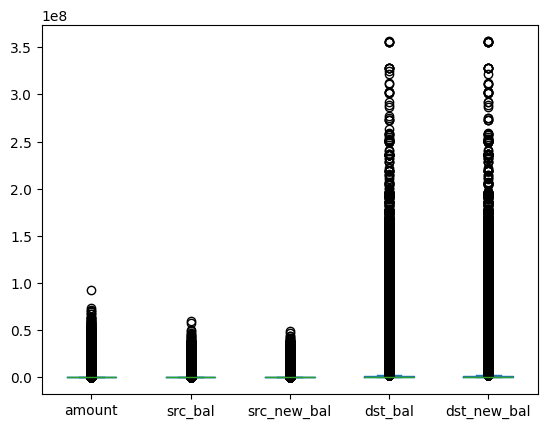

In [8]:
import matplotlib.pyplot as plt

numbers = duckdb.sql(
f"""
SELECT amount, src_bal, src_new_bal, dst_bal, dst_new_bal
FROM '{get_path()}'
"""
).fetchdf()

numbers.plot(kind='box')
plt.show()

In [9]:
numbers.describe()

,amount,src_bal,src_new_bal,dst_bal,dst_new_bal
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


# 2. Relationship between each feature to the target

## 2.1 transaction type

### findings:
- Only two types of transactions present fraudulent transactions: TRANSFER, CASH_OUT
- TRANSFER is a lot more likely to be fraudulent than CASH_OUT. (~4.3 folds)

### actions:
- rule: if a transaction is not TRANSFER nor CASH_OUT, it is considered non-fraudulent.
- action: drop transactions that are not TRANSFER nor CASH_OUT in the training part.

In [10]:
duckdb.sql(f"""
SELECT 
    transac_type, 
    SUM(is_fraud) AS total_fraud,
    COUNT(*) AS total_transactions,
    ROUND(total_fraud * 100.0 / total_transactions, 2) AS fraud_percentage
FROM '{get_path()}'
GROUP BY transac_type
ORDER BY fraud_percentage DESC
"""
).show()

┌──────────────┬─────────────┬────────────────────┬──────────────────┐
│ transac_type │ total_fraud │ total_transactions │ fraud_percentage │
│   varchar    │   int128    │       int64        │      double      │
├──────────────┼─────────────┼────────────────────┼──────────────────┤
│ TRANSFER     │        4097 │             532909 │             0.77 │
│ CASH_OUT     │        4116 │            2237500 │             0.18 │
│ PAYMENT      │           0 │            2151495 │              0.0 │
│ CASH_IN      │           0 │            1399284 │              0.0 │
│ DEBIT        │           0 │              41432 │              0.0 │
└──────────────┴─────────────┴────────────────────┴──────────────────┘



## 2.2 Flagged fraud

### findings:
- if the transaction is flagged as fraud, it is 100% to be a fraud according to the dataset.
- flagged fraud characteristics:
    - all are fraud
    - "TRANSFER" type
    - 'dst_bal' and 'dst_new_bal' are all 0.0
    - note: amount can exceed 200k, conflicted with what is told in the data description.

### Actions: 
- Considering that only 16 records that is_flagged_fraud is True (out of ~8k fraud transactions), **we can remove this feauture because it has too little variance.**
- however, it kind of implies that dst_bal, dst_new_bal, and transac_type are quite relevant.

In [11]:
duckdb.sql(f"""
SELECT 
    is_flagged_fraud , 
    COUNT(*) AS total_flagged,
    SUM(is_fraud) AS total_fraud,
FROM '{get_path()}'
GROUP BY is_flagged_fraud 
"""
).show()

┌──────────────────┬───────────────┬─────────────┐
│ is_flagged_fraud │ total_flagged │ total_fraud │
│      int64       │     int64     │   int128    │
├──────────────────┼───────────────┼─────────────┤
│                1 │            16 │          16 │
│                0 │       6362604 │        8197 │
└──────────────────┴───────────────┴─────────────┘



all 16 transactions with `is_flagged_fraud` = 1

In [12]:
duckdb.sql(f"""
SELECT *
FROM '{get_path()}'
WHERE is_flagged_fraud = 1
""").show()

┌──────────┬──────────────┬────────────┬────────────┬─────────────┬─────────────┬────────────┬─────────┬─────────────┬──────────┬──────────────────┐
│ time_ind │ transac_type │   amount   │  src_acc   │   src_bal   │ src_new_bal │  dst_acc   │ dst_bal │ dst_new_bal │ is_fraud │ is_flagged_fraud │
│  int64   │   varchar    │   double   │  varchar   │   double    │   double    │  varchar   │ double  │   double    │  int64   │      int64       │
├──────────┼──────────────┼────────────┼────────────┼─────────────┼─────────────┼────────────┼─────────┼─────────────┼──────────┼──────────────────┤
│      212 │ TRANSFER     │ 4953893.08 │ acc2680695 │  4953893.08 │  4953893.08 │ acc8084602 │     0.0 │         0.0 │        1 │                1 │
│      250 │ TRANSFER     │ 1343002.08 │ acc8152455 │  1343002.08 │  1343002.08 │ acc6721727 │     0.0 │         0.0 │        1 │                1 │
│      279 │ TRANSFER     │  536624.41 │ acc5456401 │   536624.41 │   536624.41 │ acc2588125 │     0.0 │  

## 2.3 amount

### findings:
- a lot of fraudulent transactions have amount = 10,000,000
- when the amount of the transaction is divisable by 100x, they are a lot more likely to be fradulent (compared to when the amount is not divisable by 100x). This means `amount` feature is relevant.

In [13]:
duckdb.sql(
f"""
SELECT
    FLOOR(amount) AS approx_amount,
    SUM(is_fraud) AS total_fraud
FROM '{get_path()}'
GROUP BY approx_amount
ORDER BY total_fraud DESC
LIMIT 10
"""
).show()

┌───────────────┬─────────────┐
│ approx_amount │ total_fraud │
│    double     │   int128    │
├───────────────┼─────────────┤
│    10000000.0 │         287 │
│           0.0 │          16 │
│       32382.0 │           4 │
│     1165187.0 │           4 │
│      537539.0 │           4 │
│      125464.0 │           4 │
│        9065.0 │           4 │
│         119.0 │           4 │
│      429257.0 │           4 │
│       18887.0 │           4 │
├───────────────┴─────────────┤
│ 10 rows           2 columns │
└─────────────────────────────┘



In [14]:
def print_fraud_mod_by_amount(x):
    duckdb.sql(
    f"""
    WITH divised AS (
    SELECT
        is_fraud,
        IF(MOD(amount, {x}) = 0, true, false) AS divisable_by_{x}
    FROM '{get_path()}'
    )
    
    SELECT
        divisable_by_{x},
        COUNT(*) AS total_transactions,
        SUM(is_fraud) AS total_fraud,
        ROUND(total_fraud * 100 / total_transactions, 2) AS fraud_percentage
    FROM divised
    GROUP BY divisable_by_{x}
    ORDER BY divisable_by_{x} DESC
    """
    ).show()

for x in [10_000_000, 1_000_000, 100_000, 10_000, 1_000, 100, 10]:
    print_fraud_mod_by_amount(x)

┌───────────────────────┬────────────────────┬─────────────┬──────────────────┐
│ divisable_by_10000000 │ total_transactions │ total_fraud │ fraud_percentage │
│        boolean        │       int64        │   int128    │      double      │
├───────────────────────┼────────────────────┼─────────────┼──────────────────┤
│ true                  │               3223 │         303 │              9.4 │
│ false                 │            6359397 │        7910 │             0.12 │
└───────────────────────┴────────────────────┴─────────────┴──────────────────┘

┌──────────────────────┬────────────────────┬─────────────┬──────────────────┐
│ divisable_by_1000000 │ total_transactions │ total_fraud │ fraud_percentage │
│       boolean        │       int64        │   int128    │      double      │
├──────────────────────┼────────────────────┼─────────────┼──────────────────┤
│ true                 │               3223 │         303 │              9.4 │
│ false                │            6359397 

## 2.4 Balance before/after transaction

### finding:
- when the destination balance before/after the transaction are both zero, the transaction has more chance to be a fraudulent. This means, `dst_bal and dst_new_bal` features are relevant.

In [15]:

duckdb.sql(f"""
SELECT 
    IF(dst_bal = 0 AND dst_new_bal = 0, true, false) AS dstBal_AND_dstNewBal_are_zero,
    COUNT(*) AS total_transactions,
    SUM(is_fraud) AS total_fraud,
    ROUND(total_fraud * 100 / total_transactions, 2) AS fraud_percentage
FROM '{get_path()}'
WHERE transac_type IN ('TRANSFER', 'CASH_OUT')
GROUP BY dstBal_AND_dstNewBal_are_zero
ORDER BY dstBal_AND_dstNewBal_are_zero DESC
""")

┌───────────────────────────────┬────────────────────┬─────────────┬──────────────────┐
│ dstBal_AND_dstNewBal_are_zero │ total_transactions │ total_fraud │ fraud_percentage │
│            boolean            │       int64        │   int128    │      double      │
├───────────────────────────────┼────────────────────┼─────────────┼──────────────────┤
│ true                          │               5782 │        4076 │            70.49 │
│ false                         │            2764627 │        4137 │             0.15 │
└───────────────────────────────┴────────────────────┴─────────────┴──────────────────┘

## 2.5 Time_ind

### findings:
- time_ind of non-fraud transactions seems to follow some pattern.
- after convert time_ind into hour of the day and day of the month, we can see the patterns of the number of transactions and fraud percentage:
    -  We can see from the plot that transactions usually take place after 9 am. Transactions before 9 am are more likely to be fraudulent than other times.
    -  There are 2 particular days when there is high chance that fraudulent transactions take place, that are 4th and the last day in the data.

### actions:
- new feature: `hour_of_day = MOD(time_ind, 24)`
- new feature: `day_of_month = CAST((time_ind / 24) + 1 AS INTEGER)`

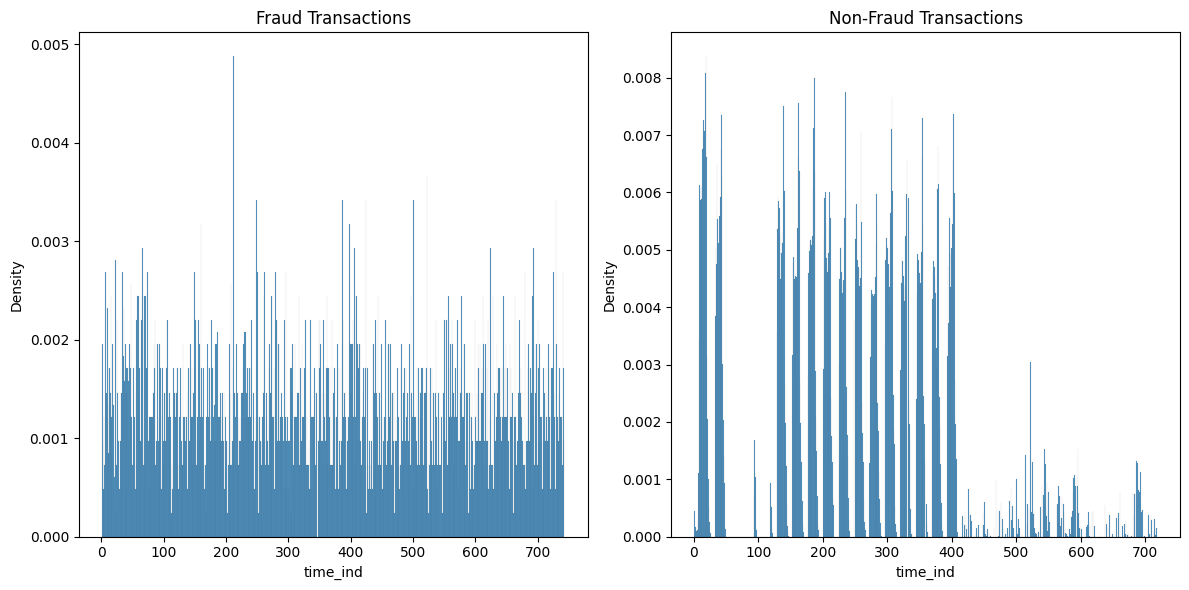

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(duckdb.sql(f"SELECT time_ind FROM '{get_path()}' WHERE is_fraud = 1").fetchdf(), x = 'time_ind', bins=743, stat='density', label='Fraud', ax=ax[0])
sns.histplot(duckdb.sql(f"SELECT time_ind FROM '{get_path()}' WHERE is_fraud = 0").fetchdf(), x = 'time_ind', bins=743, stat='density', label='Fraud', ax=ax[1])

ax[0].set_title('Fraud Transactions')
ax[1].set_title('Non-Fraud Transactions')
plt.tight_layout()
plt.show()

Since time_ind is in 1 hour unit, we can convert it roughly to hour of the day (0-23), and day of the month (1-31). From the plot below, we can see that transactions usually take place after 9 am. Transactions before 9 am are more likely to be fraudulent than other times.

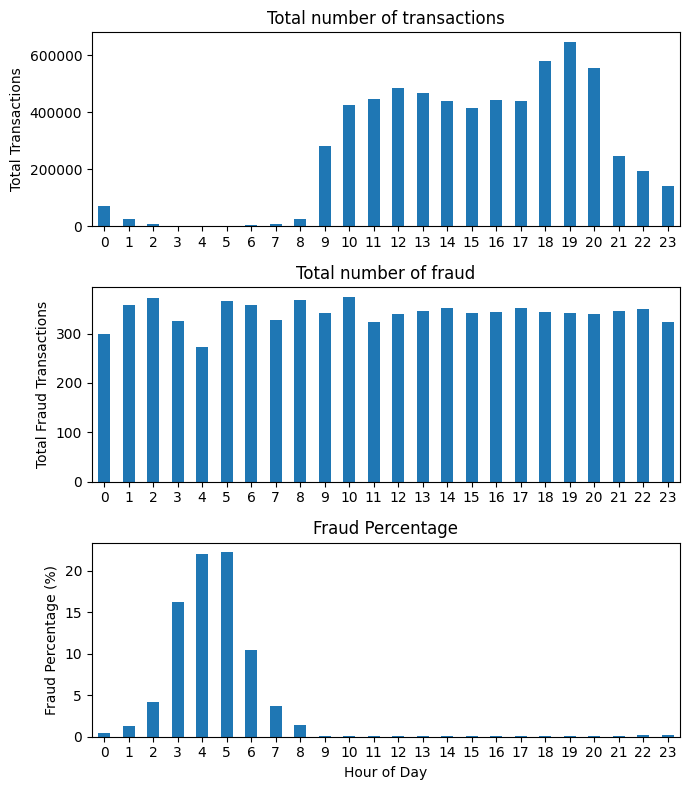

In [17]:
by_hours = duckdb.sql(f"""
SELECT
    MOD(time_ind, 24) AS hour_of_day,
    SUM(is_fraud) AS total_fraud,
    COUNT(*) AS total_transactions,
    ROUND(total_fraud * 100.0 / total_transactions, 2) AS fraud_percentage
FROM '{get_path()}'
GROUP BY hour_of_day
ORDER BY fraud_percentage DESC
""").fetchdf()

fig, ax = plt.subplots(3, 1, figsize=(7, 8))

by_hours.sort_values(by='hour_of_day').plot(x='hour_of_day', y='total_transactions', kind='bar', title='Total number of transactions', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Total Transactions')
ax[0].tick_params(axis='x', labelrotation=0)
ax[0].get_legend().remove()

by_hours.sort_values(by='hour_of_day').plot(x='hour_of_day', y='total_fraud', kind='bar', title='Total number of fraud', ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('Total Fraud Transactions')
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].get_legend().remove()

by_hours.sort_values(by='hour_of_day').plot(x='hour_of_day', y='fraud_percentage', kind='bar', title='Fraud Percentage', ax=ax[2])
ax[2].set_xlabel('Hour of Day')
ax[2].set_ylabel('Fraud Percentage (%)')
ax[2].tick_params(axis='x', labelrotation=0)
ax[2].get_legend().remove()

plt.tight_layout()
plt.show()

Moreover there are 2 particular days when there is high chance that fraudulent transactions take place, that are 4th and the last day in the data.

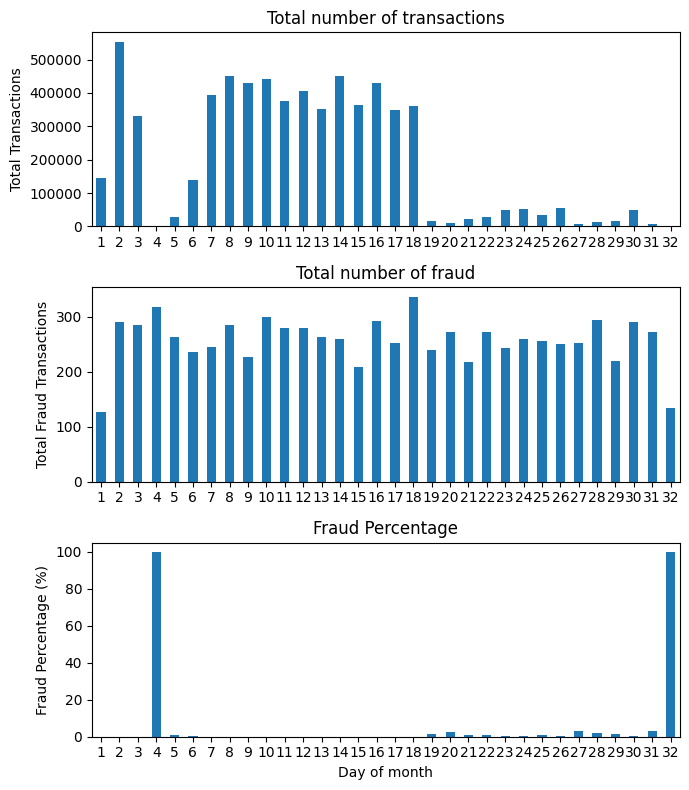

In [19]:
by_day = duckdb.sql(f"""
SELECT
    CAST((time_ind / 24) + 1 AS INTEGER) AS day_of_month,
    SUM(is_fraud) AS total_fraud,
    COUNT(*) AS total_transactions,
    ROUND(total_fraud * 100.0 / total_transactions, 2) AS fraud_percentage
FROM '{get_path()}'
GROUP BY day_of_month
ORDER BY fraud_percentage DESC
""").fetchdf()

fig, ax = plt.subplots(3, 1, figsize=(7, 8))

by_day.sort_values(by='day_of_month').plot(x='day_of_month', y='total_transactions', kind='bar', title='Total number of transactions', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Total Transactions')
ax[0].tick_params(axis='x', labelrotation=0)
ax[0].get_legend().remove()

by_day.sort_values(by='day_of_month').plot(x='day_of_month', y='total_fraud', kind='bar', title='Total number of fraud', ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('Total Fraud Transactions')
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].get_legend().remove()

by_day.sort_values(by='day_of_month').plot(x='day_of_month', y='fraud_percentage', kind='bar', title='Fraud Percentage', ax=ax[2])
ax[2].set_xlabel('Day of month')
ax[2].set_ylabel('Fraud Percentage (%)')
ax[2].tick_params(axis='x', labelrotation=0)
ax[2].get_legend().remove()

plt.tight_layout()
plt.show()